## Making Product Counts Final Project

Team: Jessie, Claire, Stuart, Wendy<br>
ID: junghsuc, yijuw, shihhao2, pingjouc

In [1]:
# import file please organize all the import here
import re
import nltk
import datetime

import pandas as pd
import numpy as np
import seaborn as sns
import word2vec
from matplotlib import pyplot as plt
from bs4 import BeautifulSoup
from textblob import TextBlob

from nltk import ngrams
from nltk.corpus import stopwords
from nltk import PorterStemmer
from nltk.stem.wordnet import  WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

In [2]:
pd.set_option('display.max_colwidth', -1)

## Reading data from Excel

In [3]:
# Prepare file array for loading excel files
# 2 has already loaded
parse_dates = ['Published Date (GMT-04:00) New York']

EXCEL_START = 3
EXCEL_END   = 11
excel_file  = []

for i in range(EXCEL_START, EXCEL_END + 1):
    file_name = str(i) + ".xlsx"
    excel_file.append(file_name)
    
excel_file

['3.xlsx',
 '4.xlsx',
 '5.xlsx',
 '6.xlsx',
 '7.xlsx',
 '8.xlsx',
 '9.xlsx',
 '10.xlsx',
 '11.xlsx']

In [4]:
# preload 2.xlsx to build dataframe columns
df = pd.read_excel("2.xlsx", encoding = 'utf8', parse_dates=parse_dates)

In [5]:
for file in excel_file:
    tmp_df = pd.read_excel(file, encoding = 'utf8')
    df = df.append(tmp_df)

In [6]:
# filter the selected columns
df = df[['Sound Bite Text',
         'Title', 'Post Type',
         'Published Date (GMT-04:00) New York',
         'Source Type',
         'No. of Followers/Daily Unique Visitors',
         'Author Gender',
         'Positive Objects',
         'Negative Objects',
         'Author Location - Country 1']]

## Reading Twitter Data

In [7]:
# Reading Twitter data
# uncomment this if you're processing with twitter data

#twtter_3 = pd.read_excel("T3.xlsx")
#twtter_9 = pd.read_excel("T9.xlsx")

In [8]:
# filter out the original data
origin = df[df['Post Type'] == 'Original']

In [9]:
origin.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 380296 entries, 3 to 23321
Data columns (total 10 columns):
Sound Bite Text                           380296 non-null object
Title                                     284165 non-null object
Post Type                                 380296 non-null object
Published Date (GMT-04:00) New York       380296 non-null object
Source Type                               380296 non-null object
No. of Followers/Daily Unique Visitors    380296 non-null float64
Author Gender                             380296 non-null object
Positive Objects                          83010 non-null object
Negative Objects                          37556 non-null object
Author Location - Country 1               120501 non-null object
dtypes: float64(1), object(9)
memory usage: 31.9+ MB


# Ultility Functions

### Emoji Translator
Translate text emojis to the real text so we can process it later.

In [10]:
# Emoji trnaslator
# Happy Emoticons

happy = set([
    ':-)', ':)', ';)', ':o)', ':]', ':3', ':c)', ':>', '=]', '8)', '=)', ':}',
    ':^)', ':-D', ':D', '8-D', '8D', 'x-D', 'xD', 'X-D', 'XD', '=-D', '=D',
    '=-3', '=3', ':-))', ":'-)", ":')", ':*', ':^*', '>:P', ':-P', ':P', 'X-P',
    'x-p', 'xp', 'XP', ':-p', ':p', '=p', ':-b', ':b', '>:)', '>;)', '>:-)',
    '<3'
    ])
 
# Sad Emoticons
sad = set([
    ':L', ':-/', '>:/', ':S', '>:[', ':@', ':-(', ':[', ':-||', '=L', ':<',
    ':-[', ':-<', '=\\', '=/', '>:(', ':(', '>.<', ":'-(", ":'(", ':\\', ':-c',
    ':c', ':{', '>:\\', ';('
    ])

def translate_emoji(word):
    if word in happy:
        return "happyface"
    elif word in sad:
        return "sadface"
    else:
        return word

## Text preprocessing utility function

In [11]:
def comment_to_words(raw_comment, count=1):

    # 1. Remove HTML
    review_text = BeautifulSoup(raw_comment, "html.parser").get_text() 
    
    # 2. Translate Emoji
    textify_emoji = [translate_emoji(w) for w in review_text]
    
    # 3. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", ''.join(textify_emoji))  # Replace special character with " "
    letters_only = re.sub("_", " ", letters_only)
    letters_only = re.sub("\s+", " ", letters_only) # Change any white space to one space
                                  
    # 4. Convert to lower case, split into individual words
    words = letters_only.lower().split()                             
    
    # 5. In Python, searching a set is much faster than searching a list, so convert the stop words to a set
    stops = set(stopwords.words("english")) # Stopwords: 'i', 'me', 'my', 'myself', 'we', 'our' etc.             
    
    # 6. Remove stop words from comment
    meaningful_words = [w for w in words if not w in stops]
    meaningful_words = [w for w in meaningful_words if w != "xxxx" and w != "xxx" and w != "xx"]
    #meaningful_words = [w for w in meaningful_words if w.lower() != "samsung" and w.lower() != "galaxy" and w.lower() != "s8"] #change
    #meaningful_words = [w for w in meaningful_words if w.lower() != "apple" and w.lower() != "iphone"]
    

    # 7. Stemming and Lemmatization
    wordnet_lemmatizer = WordNetLemmatizer()
    porter_stemmer = PorterStemmer()
    meaningful_wordsNP = np.array([])
    

       
    for w in meaningful_words:
        lemmWord = wordnet_lemmatizer.lemmatize(w)
        meaningful_wordsNP = np.append(meaningful_wordsNP, lemmWord)
        porterWord = porter_stemmer.stem(lemmWord)
        
    if (count % 5000 == 0):
        print(str(count))
    
    return meaningful_wordsNP

In [12]:
# testing comment_to_words function
test = comment_to_words("Hi.  Just curious.  Are you guys taking pre-orders on the Samsung Galaxy S8?  If so, which branch and from when can we put our names down?  Thanks!")
test

array(['hi', 'curious', 'guy', 'taking', 'pre', 'order', 'samsung',
       'galaxy', 'branch', 'put', 'name', 'thanks'], dtype='<U32')

In [13]:
# Build a self-designed Tokenizer
stop = stopwords.words('english')
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

def fourOfourTokenizer(text):
    # Allow only ascii character and numbers
    ascii_letter = re.sub("[^A-Za-z0-9]", " ", text)
    
    # tokenize using nltk tokenizer
    tokens = nltk.word_tokenize(ascii_letter)[2:]
    
    # lower the whole text
    lower_case = [word.lower() for word in tokens]
    
    # removed english stop words from nltk English stop word dictionary
    stop_word_removed = [word for word in lower_case if word not in (stop)]
    
    # stemmed the words using nltk PorterStemmer
#     ps_text = [ps.stem(w) for w in stop_word_removed]
    
    # lemmatized the words using Wordnet Lemmatizer
    lemmatized_text = [lemmatizer.lemmatize(w) for w in stop_word_removed]
    
    return lemmatized_text

In [14]:
def get_BOW_weight(raw_df):
    
    vect = CountVectorizer(encoding='latin-1',ngram_range=(1,2)).fit(raw_df['Sound Bite Text']) #,ngram_range=(1,2)
    clean_text_vectorized = vect.fit_transform(raw_df['Sound Bite Text']) 

    sortDF = raw_df.sort_values(by = ['Sentiment'],ascending=False)

    pos = sortDF[sortDF['Sentiment'] == 'Positive']
    posNum = pos.shape[0]
    total = sortDF.shape[0]
    
    #the first pos number are positive and the rest are negative.
    target = [1 if i <= posNum else 0 for i in range(total)]

    final_model = LogisticRegression(C=0.05)
    final_model.fit(clean_text_vectorized, target)
    
    feature_to_coef = {
        word: coef for word, coef in zip(
            vect.get_feature_names(), final_model.coef_[0]
        )
    }
    

    print ("Postive:\n")
    
    for best_positive in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1], 
        reverse=True)[:500]:
        print (best_positive)
    
    print()
    print ("Negative:\n")
    
    for best_negative in sorted(
        feature_to_coef.items(), 
        key=lambda x: x[1])[:500]:
        print (best_negative)
        

In [15]:
# build bunches of ngrams of word
def ngrams(input_list):
    onegrams = input_list
    bigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:]))]
#     trigrams = [' '.join(t) for t in list(zip(input_list, input_list[1:], input_list[2:]))]
    return np.append(onegrams, bigrams).tolist()

In [16]:
# Copy the dataframe from origin
socialT = origin.copy()
socialT.drop_duplicates()
socialT = socialT.fillna('')
socialT = socialT.reset_index()

In [17]:
def blob_sentiment(text):
    b = TextBlob(text)
    return b.sentiment.polarity

# Preprocessing Data

In [18]:
socialT.loc[:, 'lower_text']  = socialT['Sound Bite Text'].apply(lambda x: x.lower())

In [19]:
socialT.loc[:, 'clear_text'] = socialT['Sound Bite Text'].apply(lambda x: comment_to_words(x))

In [20]:
socialT.loc[:, 'clear_text_str'] = socialT['clear_text'].apply(lambda x: ' '.join(x))

In [21]:
socialT.loc[:, 'blob_sentiment1'] = socialT['clear_text_str'].apply(lambda x: blob_sentiment(x))

In [22]:
socialT.loc[:, 'clear_text_ngram2'] = socialT['clear_text'].apply(lambda x: ngrams(x))

In [23]:
socialT.head()

index  \
0  3       
1  5       
2  6       
3  9       
4  11      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   Sound Bite Text  \
0  Samsung's Galaxy S8 phone aims to dispel the Note 7 debacle Technology Samsung’s Galaxy S8 phone aims to dispel the Note 7 debacle Samsung seems to be playing it safe —at least with its battery — as it unveils its first major smartphone since the embarrassing recall of its fire-prone Note 7. The Galaxy S8 will come in two sizes, both bigger than comparable models from last year. To maximize display space, there’s no more physical home button. That’s a big bet that its phones will justify a higher price, whereas it could have used these new phones as a way to drive higher sales after a couple of years of stagnation.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    
1  Microsoft Has Its Own Special Editions of the Samsung Galaxy S8 & S8+ Microsoft apps have long been a staple of Samsung’s smartphones, but now the two tech giants are going one step further by launching a special “Microsoft Edition” of the newly unveiled Galaxy S8 and S8+. Featuring all the same tech specs, the exclusive smartphones add the likes of Outlook to the usual suite of Office apps and OneDrive. Oddly enough, however, the phones also utilize Microsoft’s Cortana virtual assistant – this despite the fact that the Galaxy S8/S8+ launch is supposed to be the big rollout for Samsung’s own highly touted (and potentially superior) Bixby. Nonetheless, the special editions of the smartphones are reportedly available to pre-order now exclusively at Microsoft’s own flagship stores. Click here to view full gallery at Hypebeast.com                                                                                                                                                                                                                                                                                                            
2  Hello Malaysia MIUI-Ers ! Samsung and Microsoft are taking their relationship to the following level with an uncommon Samsung Galaxy S8 Microsoft Edition that might be accessible online at Microsoft's webstore. While the standard S8 as of now comes pre-stacked with Microsoft's Office applications, the redid form additionally includes Cortana (Microsoft's AI associate), Excel, Outlook, OneDrive, One Note, Bing, Groove, Skype, MSN News and the sky is the limit from there. The custom software will b

In [24]:
socialT.loc[:,'Positive Objects'] = socialT['Positive Objects'].replace(r'', np.NaN)
socialT.loc[:,'Negative Objects'] = socialT['Negative Objects'].replace(r'', np.NaN)

In [25]:
# export dataframe
socialT.to_csv('socialT.csv')

# Extracting features using BoW

In [26]:
# applied clean text and ngram to the original text
clean_gramed_text = origin[['Sound Bite Text']]
clean_gramed_text['Sound Bite Text'] = clean_gramed_text['Sound Bite Text'].apply(lambda x : fourOfourTokenizer(x))
clean_gramed_text['Sound Bite Text'] = clean_gramed_text['Sound Bite Text'].apply(lambda x : ngrams(x))
clean_gramed_text

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


Sound Bite Text
3      [galaxy, s8, phone, aim, dispel, note, 7, debacle, technology, samsung, galaxy, s8, phone, aim, dispel, note, 7, debacle, samsung, seems, playing, safe, least, battery, unveils, first, major, smartphone, since, embarrassing, recall, fire, prone, note, 7, galaxy, s8, come, two, size, bigger, comparable, model, last, year, maximize, display, space, physical, home, button, big, bet, phone, justify, higher, price, whereas, could, used, new, phone, way, drive, higher, sale, couple, year, stagnation, galaxy s8, s8 phone, phone aim, aim dispel, dispel note, note 7, 7 debacle, debacle technology, technology samsung, samsung galaxy, galaxy s8, s8 phone, phone aim, aim dispel, dispel note, note 7, 7 debacle, debacle samsung, samsung seems, seems playing, playing safe, safe least, least battery, battery unveils, unveils first, first major, major smartphone, smartphone since, since embarrassing, embarrassing recall, recall fire, ...]                                                                                                                                                                                                                                                      
5      [special, edition, samsung, galaxy, s8, s8, microsoft, apps, long, staple, samsung, smartphones, two, tech, giant, going, one, step, launching, special, microsoft, edition, newly, unveiled, galaxy, s8, s8, featuring, tech, spec, exclusive, smartphones, add, like, outlook, usual, suite, office, apps, onedrive, oddly, enough, however, phone, also, utilize, microsoft, cortana, virtual, assistant, despite, fact, galaxy, s8, s8, launch, supposed, big, rollout, samsung, highly, touted, potentially, superior, bixby, nonetheless, special, edition, smartphones, reportedly, available, pre, order, exclusively, microsoft, flagship, store, click, view, full, gallery, hypebeast, com, special edition, edition samsung, samsung galaxy, galaxy s8, s8 s8, s8 microsoft, microsoft apps, apps long, long staple, staple samsung, samsung smartphones, smartphones two, two tech, tech giant, giant going, going one, one step, ...]                                                                                                                                                                                                                                                                          
6      [miui, er, samsung, microsoft, taking, relationship, following, level, uncommon, samsung, galaxy, s8, microsoft, edition, might, accessible, online, microsoft, webstore, standard, s8, come, pre, stacked, microsoft, office, application, redid, form, additionally, includes, cortana, microsoft, ai, associate, excel, outlook, onedrive, one, note, bing, groove, skype, msn, news, sky, limit, custom, software, consequently, downloaded, first, run, via, smartphone, wi, fi, contrast, s8, s8, accessible, microsoft, edition, microsoft, customization, applied, samsung, galaxy, s8, galaxy, s8, microsoft, edition, device, unboxed, connected, wi, fi, say, microsoft, spokesperson, customization, ensures, customer, best, class, productivity, experience, microsoft, application, office, onedrive, cortana, outlook, conclude, official, announcement, yet, whether, s8, ...]                                                                                                                                                                                                                                                                                                                              
9      [like, samsung, gear, google, daydream, popular, thanks, low, cost, accessibility, offer, limited, interactivity, time, advanced, headset, like, htc, vive, oculus, rift, require, pricey, hardware, currently, require, tethered, home, desktop, read, apple, tim, cook, endorses, augmented, reality, may, appear, iphone, 8, ar, gaming, interactive, application, relative, infancy, iger, high, profile, supporter, p

In [27]:
df1 = clean_gramed_text.copy()
df1.reset_index(inplace = True)

In [28]:
df1.drop(df1.columns[[0]], axis=1, inplace = True)
df1

Sound Bite Text
0       [galaxy, s8, phone, aim, dispel, note, 7, debacle, technology, samsung, galaxy, s8, phone, aim, dispel, note, 7, debacle, samsung, seems, playing, safe, least, battery, unveils, first, major, smartphone, since, embarrassing, recall, fire, prone, note, 7, galaxy, s8, come, two, size, bigger, comparable, model, last, year, maximize, display, space, physical, home, button, big, bet, phone, justify, higher, price, whereas, could, used, new, phone, way, drive, higher, sale, couple, year, stagnation, galaxy s8, s8 phone, phone aim, aim dispel, dispel note, note 7, 7 debacle, debacle technology, technology samsung, samsung galaxy, galaxy s8, s8 phone, phone aim, aim dispel, dispel note, note 7, 7 debacle, debacle samsung, samsung seems, seems playing, playing safe, safe least, least battery, battery unveils, unveils first, first major, major smartphone, smartphone since, since embarrassing, embarrassing recall, recall fire, ...]                                                                                                                                                                                                                                                      
1       [special, edition, samsung, galaxy, s8, s8, microsoft, apps, long, staple, samsung, smartphones, two, tech, giant, going, one, step, launching, special, microsoft, edition, newly, unveiled, galaxy, s8, s8, featuring, tech, spec, exclusive, smartphones, add, like, outlook, usual, suite, office, apps, onedrive, oddly, enough, however, phone, also, utilize, microsoft, cortana, virtual, assistant, despite, fact, galaxy, s8, s8, launch, supposed, big, rollout, samsung, highly, touted, potentially, superior, bixby, nonetheless, special, edition, smartphones, reportedly, available, pre, order, exclusively, microsoft, flagship, store, click, view, full, gallery, hypebeast, com, special edition, edition samsung, samsung galaxy, galaxy s8, s8 s8, s8 microsoft, microsoft apps, apps long, long staple, staple samsung, samsung smartphones, smartphones two, two tech, tech giant, giant going, going one, one step, ...]                                                                                                                                                                                                                                                                          
2       [miui, er, samsung, microsoft, taking, relationship, following, level, uncommon, samsung, galaxy, s8, microsoft, edition, might, accessible, online, microsoft, webstore, standard, s8, come, pre, stacked, microsoft, office, application, redid, form, additionally, includes, cortana, microsoft, ai, associate, excel, outlook, onedrive, one, note, bing, groove, skype, msn, news, sky, limit, custom, software, consequently, downloaded, first, run, via, smartphone, wi, fi, contrast, s8, s8, accessible, microsoft, edition, microsoft, customization, applied, samsung, galaxy, s8, galaxy, s8, microsoft, edition, device, unboxed, connected, wi, fi, say, microsoft, spokesperson, customization, ensures, customer, best, class, productivity, experience, microsoft, application, office, onedrive, cortana, outlook, conclude, official, announcement, yet, whether, s8, ...]                                                                                                                                                                                                                                                                                                                              
3       [like, samsung, gear, google, daydream, popular, thanks, low, cost, accessibility, offer, limited, interactivity, time, advanced, headset, like, htc, vive, oculus, rift, require, pricey, hardware, currently, require, tethered, home, desktop, read, apple, tim, cook, endorses, augmented, reality, may, appear, iphone, 8, ar, gaming, interactive, application, relative, infancy, iger, high, profile, supporte

In [29]:
# create S8
s8_list = []
for s in df1['Sound Bite Text']:
    if "galaxy s8" in s:
        s8_list.append(1)
    else:
        s8_list.append(0)
df1['S8'] = s8_list
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380296 entries, 0 to 380295
Data columns (total 2 columns):
Sound Bite Text    380296 non-null object
S8                 380296 non-null int64
dtypes: int64(1), object(1)
memory usage: 5.8+ MB


In [30]:
# create i8
i8_list = []
for s in df1['Sound Bite Text']:
    if "iphone 8" in s:
        i8_list.append(1)
    else:
        i8_list.append(0)
df1['i8'] = i8_list
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380296 entries, 0 to 380295
Data columns (total 3 columns):
Sound Bite Text    380296 non-null object
S8                 380296 non-null int64
i8                 380296 non-null int64
dtypes: int64(2), object(1)
memory usage: 8.7+ MB


In [31]:
# create i10
i10_list = []
for s in df1['Sound Bite Text']:
#     if "iphone 10" in s and "10" in s:
    if "iphone x" in s:
        i10_list.append(1)
    else:
        i10_list.append(0)
df1['i10'] = i10_list
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380296 entries, 0 to 380295
Data columns (total 4 columns):
Sound Bite Text    380296 non-null object
S8                 380296 non-null int64
i8                 380296 non-null int64
i10                380296 non-null int64
dtypes: int64(3), object(1)
memory usage: 11.6+ MB


# count words

In [32]:
import collections
def count_words(counter ,input):
    for word in input:
        counter[word] += 1

# S8 Bow top 500

Here we tried to extract top 500 words in Samsung Galaxy 8 and then compare it with the co-efficiency with the model we train to extract the top features of the product.

In [33]:
# s8 words
print("s8 words:")

s8_count = collections.Counter()
df1[(df1.S8 == 1)]['Sound Bite Text'].apply(lambda x: count_words(s8_count, x))
s8_count.most_common(500)

s8 words:


[('s8', 597923),
 ('galaxy', 559783),
 ('galaxy s8', 469968),
 ('samsung', 399583),
 ('samsung galaxy', 184818),
 ('phone', 171208),
 ('new', 128455),
 ('iphone', 128425),
 ('8', 107321),
 ('plus', 85204),
 ('device', 78212),
 ('screen', 75553),
 ('s8 s8', 68334),
 ('display', 68276),
 ('android', 66003),
 ('also', 65431),
 ('camera', 64755),
 ('feature', 63886),
 ('7', 63177),
 ('apple', 61545),
 ('one', 60451),
 ('like', 55931),
 ('s8 plus', 55191),
 ('note', 54992),
 ('smartphone', 54096),
 ('http', 53886),
 ('iphone 8', 52755),
 ('5', 51267),
 ('2', 49483),
 ('bixby', 46070),
 ('year', 45328),
 ('google', 45020),
 ('2017', 44660),
 ('get', 43647),
 ('first', 43241),
 ('flagship', 41080),
 ('pixel', 40071),
 ('case', 39420),
 ('come', 38433),
 ('design', 37791),
 ('edge', 37543),
 ('mobile', 36929),
 ('time', 36832),
 ('1', 36062),
 ('com', 35410),
 ('launch', 34687),
 ('look', 34414),
 ('battery', 33702),
 ('company', 33602),
 ('u', 33489),
 ('make', 33036),
 ('s8 galaxy', 32634),


# IPhone 8 BoW top 500

In [34]:
# Iphone BoW top 500
i8_count = collections.Counter()
df1[(df1.i8 == 1)]['Sound Bite Text'].apply(lambda x: count_words(i8_count, x))
i8_count.most_common(500)

[('iphone', 681676),
 ('8', 490723),
 ('iphone 8', 411041),
 ('apple', 255253),
 ('plus', 154946),
 ('new', 143666),
 ('8 plus', 123378),
 ('x', 119974),
 ('iphone x', 99117),
 ('phone', 93745),
 ('7', 81635),
 ('galaxy', 65006),
 ('camera', 63629),
 ('samsung', 57835),
 ('s8', 52559),
 ('8 iphone', 51442),
 ('also', 51198),
 ('device', 51025),
 ('feature', 49953),
 ('iphone 7', 49892),
 ('year', 48501),
 ('one', 48293),
 ('display', 45730),
 ('screen', 45664),
 ('2', 44867),
 ('http', 43936),
 ('charging', 43818),
 ('like', 43137),
 ('galaxy s8', 41456),
 ('2017', 38867),
 ('wireless', 38144),
 ('get', 37439),
 ('design', 36814),
 ('5', 34982),
 ('first', 34810),
 ('new iphone', 34568),
 ('apple iphone', 33506),
 ('model', 33207),
 ('com', 32849),
 ('case', 32745),
 ('pixel', 32431),
 ('time', 31850),
 ('note', 31245),
 ('1', 30731),
 ('smartphone', 29712),
 ('3', 29541),
 ('back', 29505),
 ('io', 29325),
 ('come', 28542),
 ('price', 28122),
 ('news', 27619),
 ('wireless charging', 27

# IPhone X Bow top 500
Here we tried to extract top 500 words in Apple iPhone 8 and then compare it with the co-efficiency with the model we train to extract the top features of the product.

In [35]:
ix_count = collections.Counter()
df1[(df1.i10 == 1)]['Sound Bite Text'].apply(lambda x: count_words(ix_count, x))
ix_count.most_common(500)

[('iphone', 341078),
 ('8', 201159),
 ('iphone 8', 161684),
 ('apple', 115847),
 ('x', 115424),
 ('iphone x', 104196),
 ('plus', 73122),
 ('new', 64726),
 ('8 plus', 61122),
 ('phone', 40530),
 ('8 iphone', 34919),
 ('7', 32325),
 ('camera', 26842),
 ('charging', 26334),
 ('also', 23357),
 ('galaxy', 23063),
 ('wireless', 22729),
 ('feature', 22511),
 ('device', 21702),
 ('iphone 7', 20686),
 ('year', 20583),
 ('samsung', 20192),
 ('screen', 19639),
 ('one', 19400),
 ('display', 18583),
 ('2', 17511),
 ('s8', 17362),
 ('like', 17078),
 ('wireless charging', 16611),
 ('model', 15637),
 ('8 8', 15249),
 ('5', 15108),
 ('get', 15061),
 ('price', 14508),
 ('new iphone', 14461),
 ('first', 14208),
 ('galaxy s8', 14046),
 ('3', 13571),
 ('pixel', 13525),
 ('time', 13393),
 ('1', 13342),
 ('apple iphone', 13004),
 ('2017', 12937),
 ('design', 12882),
 ('come', 12830),
 ('smartphone', 11826),
 ('iphones', 11731),
 ('x iphone', 11531),
 ('note', 11494),
 ('launch', 11218),
 ('glass', 11067),
 (

# Top features:

## Samsung S8
Infinity Display, <br>
Snapdragon,<br>
Home button,<br>
wireless charging,<br>
fingerprint sensor,<br>
iris sensor,<br>
battery life,<br>
Facial detection,<br>
Price<br>

## Iphone 8
OLED Display <br>
Wireless charging<br> 
Augmented Reality<br>
Bionic<br>
Dual Camera<br>
iris sensor<br>
battery life<br>
Facial recognition<br>
Fingerprint sensor<br>
Portrait Mode<br>
Price<br>


## Iphone X
Face ID <br>
A11 Bionic<br>
Dual Camera<br>
Glass back<br>
Charging Pad<br>
Augmented Reality<br>
Price<br>

In [36]:
socialT

index  \
0       3       
1       5       
2       6       
3       9       
4       11      
5       13      
6       16      
7       17      
8       18      
9       19      
10      24      
11      25      
12      27      
13      29      
14      31      
15      32      
16      35      
17      39      
18      40      
19      41      
20      44      
21      45      
22      46      
23      48      
24      49      
25      50      
26      51      
27      52      
28      53      
29      56      
...     ..      
380266  23286   
380267  23287   
380268  23288   
380269  23289   
380270  23290   
380271  23291   
380272  23292   
380273  23293   
380274  23294   
380275  23295   
380276  23296   
380277  23297   
380278  23298   
380279  23299   
380280  23302   
380281  23303   
380282  23304   
380283  23306   
380284  23307   
380285  23308   
380286  23309   
380287  23310   
380288  23312   
380289  23313   
380290  23314   
380291  23315   
380292  23316   
380293  23317   
380294  23319   
380295  23321   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

# Tagging Labels to each post

The dataset we got are unlabeled textual data. 
We would like to analyze it through two different approach.

1. Try to label the sentiment using the preprocessed columns, "Positive Objects" and "Negative Objects".  And then using the labeled data, to predict whole dataset. Extract those top predictors (using coef value) to find top features of each product.

2. Using NLTK library to calculate sentiment of each articles and then compare it with the result we got from the first approach.


In [37]:
# Tag Postive/ Negative to row that had a Pos or Neg Objects

socialT['Sentiment'] = "Unknown"

socialT.loc[socialT['Positive Objects'].notnull(), 'Sentiment'] = 'Positive'
socialT.loc[socialT['Negative Objects'].notnull(), 'Sentiment'] = 'Negative'

In [38]:
socialT[socialT['Sentiment'] == 'Positive']

index  \
3       9       
15      32      
17      39      
18      40      
55      97      
63      108     
83      136     
85      140     
91      146     
95      152     
98      158     
99      159     
102     162     
103     163     
105     165     
108     168     
109     169     
110     170     
111     171     
112     172     
115     176     
117     178     
119     181     
123     185     
127     189     
129     191     
132     195     
133     196     
134     197     
140     203     
...     ...     
380117  23119   
380122  23124   
380125  23127   
380135  23138   
380151  23157   
380153  23160   
380166  23173   
380174  23183   
380177  23186   
380181  23191   
380189  23199   
380193  23203   
380201  23212   
380206  23217   
380216  23227   
380219  23230   
380222  23236   
380249  23266   
380250  23267   
380256  23274   
380257  23275   
380259  23277   
380260  23278   
380262  23281   
380263  23282   
380270  23290   
380278  23298   
380279  23299   
380291  23315   
380295  23321   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         

In [39]:
# for s in range(len(socialT['clear_text'])):
#     if ('samsung' in socialT.iloc[s]['clear_text']):
#         socialT.loc[s, 'S8'] = 1
#     else: 
#         socialT.loc[s, 'S8'] = 0
   
#     if ('iphone' in socialT.iloc[s]['clear_text']):
#         socialT.loc[s, 'iPhone'] = 1
#     else:
#         socialT.loc[s, 'iPhone'] = 0

socialT.loc[socialT['clear_text_str'].str.contains('samsung'), 'S8'] = 1
socialT.loc[socialT['S8'] != 1, 'S8'] = 0
socialT.loc[socialT['clear_text_str'].str.contains('iphone'), 'iPhone'] = 1
socialT.loc[socialT['iPhone'] != 1, 'iPhone'] = 0
        


In [40]:
socialT.loc[socialT['iPhone'] == 1]

index  \
3       9       
9       19      
10      24      
15      32      
18      40      
19      41      
20      44      
23      48      
25      50      
26      51      
28      53      
29      56      
33      65      
34      66      
38      78      
41      81      
46      87      
58      102     
68      117     
70      119     
72      121     
74      124     
76      126     
78      129     
80      133     
81      134     
83      136     
88      143     
90      145     
97      157     
...     ...     
380214  23225   
380215  23226   
380216  23227   
380217  23228   
380218  23229   
380222  23236   
380224  23238   
380227  23242   
380229  23244   
380231  23246   
380233  23248   
380238  23254   
380242  23259   
380243  23260   
380245  23262   
380246  23263   
380247  23264   
380248  23265   
380252  23269   
380253  23271   
380254  23272   
380258  23276   
380260  23278   
380265  23284   
380266  23286   
380281  23303   
380283  23306   
380285  23308   
380288  23312   
380290  23314   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    Sound Bite Text  \
3       Basic headsets like the Samsung Gear and Google Daydream are popular thanks to their low cost and accessibility, but offer limited interactivity. At the same time, more advanced headsets like the HTC Vive and Oculus Rift require pricey hardware and currently require you to be tethered to a home desktop. Read: Apple’s Tim Cook Endorses Augmented Reality, Which May Appear In iPhone 8 While AR’s gaming and interactive applications are in their relative infancy, Iger isn’t the only high-profile supporter of the platform. Apple CEO Tim C

# Train Model PipeLine

In [41]:
def train_model(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=6)

    text_pipe = Pipeline([('vect', CountVectorizer(encoding='latin-1',ngram_range=(1,2))),
                          ('model', MultinomialNB())])
    
    text_pipe = text_pipe.fit(X_train, y_train)

    predicted = text_pipe.predict(X_test)
    
    accuracy = accuracy_score(predicted, y_test)
    
    print("Accuracy:", accuracy)
    print('\n')
    print(classification_report(y_test, predicted))
    
    # return the trained model
    return text_pipe

# ------------------------- S8 Sentiment Analysis start ---------------------------------

### Method to predict comment sentiment

In [42]:
# add model parameter to prevent uncessary retrain
def get_sentiment(X, y, model):
    predicted = model.predict(y['clear_text_str'])
    
#     for i in range(len(y['clear_text_str'])):
#         y.loc[i, 'Sentiment'] = predicted[i]
    
    y['Sentiment'] = predicted
    
    
    return y

### Classify S8, iPhone

In [43]:
s8DF = socialT[socialT['S8'] == 1]
s8DF = s8DF[s8DF['iPhone'] == 0]

iPDF = socialT[socialT['iPhone'] == 1]
iPDF = iPDF[iPDF['S8'] == 0]

### Extract comments already have sentiment

In [44]:
s8_pos = s8DF[s8DF['Sentiment'] == 'Positive']
s8_pos_count = s8_pos.shape[0]
print(s8_pos_count)

s8_neg = s8DF[s8DF['Sentiment'] == 'Negative']
s8_neg_count = s8_neg.shape[0]

s8_all = s8_pos.append(s8_neg)
s8_all = s8_all.reset_index()
s8_all_count = s8_all.shape[0]

25538


In [45]:
# 改用 ['clean_text']

# for c in range(s8_all_count['Sound Bite Text'].size):
#     s8_PosNeg.loc[c, 'Sound Bite Text'] = comment_to_words(s8_PosNeg.loc[c, 'Sound Bite Text'])

# print(s8_PosNeg.shape[0])

###  Use known sentiment comments to train S8 model

In [47]:
s8_model = train_model(s8_all['clear_text_str'], s8_all['Sentiment'])

Accuracy: 0.8860612554692383


             precision    recall  f1-score   support

   Negative       0.84      0.78      0.81      3503
   Positive       0.90      0.93      0.92      7696

avg / total       0.88      0.89      0.88     11199



### Predict sentiment of comments with unknown sentiment label and get complete S8 dataframe

In [48]:
s8_unknown = s8DF[s8DF['Sentiment'] == 'Unknown']
s8_unknown = s8_unknown.reset_index()

# 改用 clear_text
# for c in range(s8_unknown['Sound Bite Text'].size):
#     s8_unknown.loc[c, 'Sound Bite Text'] = comment_to_words(s8_unknown.loc[c, 'Sound Bite Text'])

s8_unknown = get_sentiment(s8_all, s8_unknown, s8_model)
s8_complete = s8_all.append(s8_unknown)
s8_complete

level_0  index  \
0      17       39      
1      55       97      
2      85       140     
3      91       146     
4      95       152     
5      98       158     
6      108      168     
7      109      169     
8      110      170     
9      111      171     
10     112      172     
11     117      178     
12     119      181     
13     129      191     
14     132      195     
15     133      196     
16     134      197     
17     140      203     
18     148      211     
19     157      220     
20     165      228     
21     172      235     
22     173      236     
23     191      254     
24     200      263     
25     222      286     
26     232      296     
27     260      325     
28     264      329     
29     266      331     
...    ...      ...     
95390  380209   23220   
95391  380210   23221   
95392  380213   23224   
95393  380220   23232   
95394  380221   23233   
95395  380226   23240   
95396  380228   23243   
95397  380234   23249   
95398  380235   23250   
95399  380236   23251   
95400  380237   23252   
95401  380239   23255   
95402  380240   23257   
95403  380241   23258   
95404  380251   23268   
95405  380255   23273   
95406  380264   23283   
95407  380271   23291   
95408  380273   23293   
95409  380274   23294   
95410  380275   23295   
95411  380276   23296   
95412  380280   23302   
95413  380282   23304   
95414  380284   23307   
95415  380286   23309   
95416  380287   23310   
95417  380289   23313   
95418  380293   23317   
95419  380294   23319   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [49]:
s8_complete = s8_complete.sort_values(by = ['Sentiment'],ascending=False)
s8_complete = s8_complete.drop(columns=['level_0', 'index'])
s8_complete = s8_complete.reset_index()


s8_complete_pos = s8_complete[s8_complete['Sentiment'] == 'Positive']
print(s8_complete_pos.shape[0])
s8_complete_neg = s8_complete[s8_complete['Sentiment'] == 'Negative']
print(s8_complete_neg.shape[0])
print(s8_complete.shape[0])

101180
31568
132748


### Get S8 weighted positive, negative words top 500

In [50]:
get_BOW_weight(s8_complete)

Postive:

('samsunggalaxys8', 0.7110834866184503)
('amazing', 0.6405721132901154)
('s8plus', 0.6365298780193973)
('unboxyourphone', 0.628891009770249)
('samsungs8', 0.6229436231622877)
('64gb', 0.5396468330695761)
('awesome', 0.53891925216947)
('gorgeous', 0.533465395944613)
('beautiful', 0.5331851680283541)
('tint fix', 0.528890544191755)
('best', 0.4956833735862217)
('galaxys8', 0.48579703387664264)
('payments', 0.4775782616790591)
('shot', 0.46715588302373673)
('replies by', 0.4645543223895715)
('the problem', 0.45847764778712335)
('entertainment', 0.45563251636459695)
('stevocandelaria', 0.45475786249633676)
('exo', 0.44295995620372863)
('unlockfusion', 0.4418510101622555)
('tags tech', 0.4408783968842222)
('shot on', 0.4334954563502919)
('rose', 0.43166799146724677)
('interesting', 0.42486376188526265)
('samsunggalaxy', 0.42311737352259976)
('liked', 0.41378539754745103)
('lte', 0.39679639142855017)
('echo', 0.39387066598012627)
('dedicated', 0.393548066390548)
('infinity', 0.3857

('leaked', -1.434860817556249)
('leak', -0.9215874911439502)
('leaks', -0.7859229633041906)
('worst', -0.7649271871094775)
('fooled', -0.7517244473754159)
('restarting', -0.7053728332606181)
('doesn work', -0.6802277717613373)
('debacle', -0.6713161907974742)
('problem', -0.6322343549476557)
('disappointed', -0.6296844932526567)
('ufs', -0.6186884252566789)
('ugly', -0.6165565222812359)
('problems', -0.6156799819917512)
('with photo', -0.6097218706312241)
('to fix', -0.5809861593316621)
('poor', -0.5642003977382818)
('fake', -0.5583965262990709)
('tech usa', -0.5520512430522676)
('bad', -0.5425682636068959)
('hackers', -0.5395384824792041)
('issues', -0.5394139050610186)
('teardown', -0.5393195365110234)
('crashes', -0.5322757106937961)
('allegedly', -0.522041266323072)
('mess', -0.5113208664631202)
('rumours', -0.5095606702202815)
('robotbanana', -0.5088497562267223)
('please fix', -0.5082334833837496)
('bug', -0.5081970261172568)
('log', -0.5079039301017645)
('upcoming samsung', -0.5

### By source

In [51]:
s8_complete = s8_all.append(s8_unknown)
s8FB = s8_complete[s8_complete['Source Type'] == 'Facebook']
s8FB_Positive = s8FB[s8FB['Sentiment'] == 'Positive']
s8FB_Negative = s8FB[s8FB['Sentiment'] == 'Negative']
print("Facebook positive:", len(s8FB_Positive) / len(s8FB))
print("Facebook negative:", len(s8FB_Negative) / len(s8FB))
print()

s8_Ins = s8_complete[s8_complete['Source Type'] == 'Instagram']
s8_Ins_Positive = s8_Ins[s8_Ins['Sentiment'] == 'Positive']
s8_Ins_Negative = s8_Ins[s8_Ins['Sentiment'] == 'Negative']
print("Instagram positive:", len(s8_Ins_Positive) / len(s8_Ins))
print("Instagram negative:", len(s8_Ins_Negative) / len(s8_Ins))
print()

s8_tum = s8_complete[s8_complete['Source Type'] == 'Tumblr']
s8_tum_Positive = s8_tum[s8_tum['Sentiment'] == 'Positive']
s8_tum_Negative = s8_tum[s8_tum['Sentiment'] == 'Negative']
print("Tumblr positive:", len(s8_tum_Positive) / len(s8_tum))
print("Tumblr negative:", len(s8_tum_Negative) / len(s8_tum))
print()

s8_blog = s8_complete[s8_complete['Source Type'] == 'Blogs']
s8_blog_Positive = s8_blog[s8_blog['Sentiment'] == 'Positive']
s8_blog_Negative = s8_blog[s8_blog['Sentiment'] == 'Negative']
print("Blogs positive:", len(s8_blog_Positive) / len(s8_blog))
print("Blogs negative:", len(s8_blog_Negative) / len(s8_blog))
print()

s8_forum = s8_complete[s8_complete['Source Type'] == 'Forums']
s8_forum_Positive = s8_forum[s8_forum['Sentiment'] == 'Positive']
s8_forum_Negative = s8_forum[s8_forum['Sentiment'] == 'Negative']
print("Forums positive:", len(s8_forum_Positive) / len(s8_forum))
print("Forums negative:", len(s8_forum_Negative) / len(s8_forum))
print()

s8_comment = s8_complete[s8_complete['Source Type'] == 'Comments']
s8_comment_Positive = s8_comment[s8_comment['Sentiment'] == 'Positive']
s8_comment_Negative = s8_comment[s8_comment['Sentiment'] == 'Negative']
print("Comments positive:", len(s8_comment_Positive) / len(s8_comment))
print("Comments negative:", len(s8_comment_Negative) / len(s8_comment))
print()

Facebook positive: 0.7756756756756756
Facebook negative: 0.22432432432432434

Instagram positive: 0.9655337768986393
Instagram negative: 0.03446622310136067

Tumblr positive: 0.6908527744826677
Tumblr negative: 0.30914722551733226

Blogs positive: 0.7509997447460223
Blogs negative: 0.2490002552539777

Forums positive: 0.7017824954936912
Forums negative: 0.29821750450630885

Comments positive: 0.7819433817903596
Comments negative: 0.2180566182096404



# -------------------- iPhone 8 Sentiment Analysis start ----------------------------

In [52]:
iPDF.loc[:,'lower_text'] = iPDF.loc[:,'lower_text'].fillna('')

### Classify iPhone 8 and iPhone X

In [53]:
iPDF.loc[iPDF['lower_text'].str.contains('iphone 8'), 'i8'] = 1
iPDF.loc[iPDF['i8'] != 1, 'i8'] = 0

iPDF.loc[iPDF['lower_text'].str.contains('iphone x'), 'iX'] = 1
iPDF.loc[iPDF['iX'] != 1, 'iX'] = 0

### Extract comments already have sentiment

In [54]:
i8_complete = iPDF[iPDF['i8'] == 1]
i8_complete = i8_complete[i8_complete['iX'] == 0]
i8_pos = i8_complete[i8_complete['Sentiment'] == 'Positive']
print(i8_pos.shape[0])
i8_neg = i8_complete[i8_complete['Sentiment'] == 'Negative']
print(i8_neg.shape[0])
i8_PosNeg = i8_pos.append(i8_neg)
i8_PosNeg = i8_PosNeg.reset_index()
print(i8_PosNeg.shape[0])

23854
12472
36326


In [55]:
# for c in range(i8_PosNeg['Sound Bite Text'].size):
#     i8_PosNeg.loc[c, 'Sound Bite Text'] = comment_to_words(i8_PosNeg.loc[c, 'Sound Bite Text'])

# print(i8_PosNeg.shape[0])

### Use known sentiment comments to train iPhone 8 model

In [56]:
i8_model = train_model(i8_PosNeg['clear_text_str'], i8_PosNeg['Sentiment'])

Accuracy: 0.8571297485777207


             precision    recall  f1-score   support

   Negative       0.81      0.76      0.78      3695
   Positive       0.88      0.91      0.89      7203

avg / total       0.86      0.86      0.86     10898



### Predict sentiment of comments with unknown sentiment label and get complete iPhone 8 dataframe

In [58]:
i8_unknown = i8_complete[i8_complete['Sentiment'] == 'Unknown']
i8_unknown = i8_unknown.reset_index()

# for c in range(i8_unknown['Sound Bite Text'].size):
#     i8_unknown.loc[c, 'Sound Bite Text'] = comment_to_words(i8_unknown.loc[c, 'Sound Bite Text'])



i8_unknown = get_sentiment(i8_PosNeg, i8_unknown, i8_model)
i8_complete2 = i8_PosNeg.append(i8_unknown)

### Get iPhone 8 weighted positive, negative words top 500

In [59]:
i8_complete2 = i8_complete2.sort_values(by = ['Sentiment'],ascending=False)

i8_complete2 = i8_complete2.drop(columns=['level_0', 'index'])
i8_complete2 = i8_complete2.reset_index()

get_BOW_weight(i8_complete2)

Postive:

('iphone8plus', 1.15628333901661)
('iphone8', 0.761756026458033)
('best', 0.7555194658294929)
('unlocked', 0.7376751435469627)
('beautiful', 0.6811483233833592)
('free', 0.6550278297738831)
('great', 0.606296573380576)
('awesome', 0.593732006494421)
('favorite', 0.588155785142218)
('interesting', 0.5474511104543822)
('pics', 0.5305389215573012)
('shot on', 0.5215576498872946)
('quick', 0.5100125019982971)
('ready', 0.5091023878365375)
('offline', 0.4942900867623082)
('photography', 0.4903751882753844)
('100 apple', 0.4841213951066776)
('on fix', 0.4784833566956117)
('gold', 0.47791557935410955)
('shotoniphone', 0.47738051648591723)
('concept', 0.47637488092028113)
('impressed', 0.47528928768771367)
('cool', 0.4668027775735827)
('time of', 0.46300003143829327)
('iphone 64gb', 0.4520824124242688)
('which could', 0.4420976315559692)
('polyvore', 0.44202967691144934)
('incredible', 0.4406135233753106)
('love', 0.4366946396899293)
('shot', 0.43432850527298544)
('shopping', 0.43332

('leaked', -1.2218744320675725)
('delayed', -1.0304968040156242)
('crashes', -1.0115837451716727)
('worst', -1.0107254406933448)
('fuck', -0.9250019796705682)
('boring', -0.9223404458672129)
('leak', -0.8330497487123836)
('bloated', -0.752361949607224)
('problem', -0.7464201307762562)
('poor', -0.7338669057694096)
('alleged', -0.7334548053588438)
('swelling', -0.7277019944087884)
('issues', -0.7009918109902118)
('investigating', -0.6895670704277407)
('bad', -0.6850444673622594)
('allegedly', -0.6751982848330303)
('dumb', -0.6711137415785268)
('issue', -0.6636732248262299)
('problems', -0.6632332531534315)
('leaks', -0.6366493066751538)
('expensive', -0.5905043873722589)
('tags news', -0.5838549748915771)
('ridiculous', -0.5810281244276919)
('iphone might', -0.5792183266858035)
('delay', -0.5718075875333377)
('headlines', -0.5625107242570835)
('cracked', -0.5593251389629221)
('iphone may', -0.5564655396646152)
('hate', -0.5541994658470698)
('ofc we', -0.5533372409902474)
('well ofc', -0

In [60]:
#i8_complete2.to_csv('i8_complete.csv')

# -------------------- iPhone X Sentiment Analysis start ----------------------------

### Extract comments already have sentiment

In [61]:
iX_complete = iPDF[iPDF['iX'] == 1]
iX_complete = iX_complete[iX_complete['i8'] == 0]
iX_pos = iX_complete[iX_complete['Sentiment'] == 'Positive']
print(iX_pos.shape[0])
iX_neg = iX_complete[iX_complete['Sentiment'] == 'Negative']
print(iX_neg.shape[0])
iX_PosNeg = iX_pos.append(iX_neg)
iX_PosNeg = iX_PosNeg.reset_index()
print(iX_PosNeg.shape[0])

139
74
213


In [62]:
# for c in range(iX_PosNeg['Sound Bite Text'].size):
#     iX_PosNeg.loc[c, 'Sound Bite Text'] = comment_to_words(iX_PosNeg.loc[c, 'Sound Bite Text'])

# print(iX_PosNeg.shape[0])

### Use known sentiment comments to train iPhone X model

In [63]:
iX_model = train_model(iX_PosNeg['clear_text_str'], iX_PosNeg['Sentiment'])

Accuracy: 0.875


             precision    recall  f1-score   support

   Negative       0.76      0.76      0.76        17
   Positive       0.91      0.91      0.91        47

avg / total       0.88      0.88      0.88        64



###  Predict sentiment of comments with unknown sentiment label and get complete iPhone X dataframe

In [64]:
iX_unknown = iX_complete[iX_complete['Sentiment'] == 'Unknown']
iX_unknown = iX_unknown.reset_index()

# for c in range(iX_unknown['Sound Bite Text'].size):
#     iX_unknown.loc[c, 'Sound Bite Text'] = comment_to_words(iX_unknown.loc[c, 'Sound Bite Text'])

iX_unknown = get_sentiment(iX_PosNeg, iX_unknown, iX_model)
iX_complete2 = iX_PosNeg.append(iX_unknown)
iX_complete2

level_0  index  \
0    13067    14179   
1    95891    5430    
2    96118    5709    
3    100390   11210   
4    101050   12052   
5    101952   13186   
6    102709   14115   
7    103551   15139   
8    103905   15567   
9    107914   20697   
10   109042   22138   
11   110590   24056   
12   110701   24193   
13   111288   24851   
14   112075   25872   
15   113073   27145   
16   113540   27721   
17   114856   29359   
18   115406   30142   
19   116806   32007   
20   116942   32258   
21   117110   32494   
22   119093   35202   
23   120229   36486   
24   121818   38410   
25   121857   38466   
26   121913   38533   
27   121954   38582   
28   123358   40253   
29   124906   42015   
..      ...     ...   
439  264112   12388   
440  264235   12521   
441  264347   12656   
442  264391   12720   
443  264641   13038   
444  265038   13529   
445  265053   13547   
446  265361   13927   
447  265640   14413   
448  266715   15739   
449  266901   16005   
450  267453   16660   
451  267752   16985   
452  268214   17519   
453  268332   17679   
454  268340   17687   
455  268913   18339   
456  268984   18422   
457  269136   18589   
458  269139   18592   
459  269154   18608   
460  269320   18822   
461  269399   18965   
462  269402   18969   
463  269406   18975   
464  270214   20023   
465  270904   20870   
466  270989   21005   
467  271001   21025   
468  271116   21167   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              Sound Bite Text  \
0    Designer Gabor Balogh has envisioned the iPhone X , an Apple smartphone concept that focuses on augmented reality features. The Hungarian designer shows an edge to edge iPhone , with not one but several digital buttons below the actual screen. Large portions of the device’s front remind me of the Galaxy S8, to be honest, curved edges and all. We may have a singular touch Home button, focused on Siri and AR, but there are also 4 contextual buttons, two on each side of the Home button. Siri is now able to recognize objects and direct you using AR features.                                                                                                                                                                                                                                            

### Get iPhone X weighted positive, negative words top 500

In [65]:
iX_complete2 = iX_complete2.sort_values(by = ['Sentiment'],ascending=False)

iX_complete2 = iX_complete2.drop(columns=['level_0', 'index'])
iX_complete2 = iX_complete2.reset_index()

get_BOW_weight(iX_complete2)

Postive:

('galaxy', 0.23807849460663694)
('oneplus', 0.2220451353046929)
('now', 0.2129195402912901)
('iphone', 0.20630183351079137)
('you', 0.20140185166831492)
('has', 0.18659686648344997)
('new', 0.16809859242495725)
('is the', 0.1625784273952129)
('screen', 0.1596438341452472)
('more', 0.1591654229809387)
('your', 0.13937893642395804)
('features', 0.13676292084421074)
('on', 0.13164274054428834)
('only', 0.12761787082302453)
('are', 0.12211310204579824)
('in the', 0.11976853319521094)
('twitter', 0.11419015176939644)
('buy', 0.11390196694684247)
('which', 0.11382907110794832)
('like', 0.10976418385463224)
('galaxy s8', 0.10559905586107189)
('been', 0.10483217331331447)
('up', 0.10459434945950752)
('price', 0.10394012440656554)
('charging', 0.10360180211594369)
('front', 0.1011989063814115)
('while', 0.10076670269256878)
('pixel xl', 0.10048035478048259)
('https', 0.10034741198025106)
('you can', 0.09841546048245778)
('edge', 0.09653795639410276)
('the notch', 0.09449482538386632)


In [73]:
#iX_complete2.to_csv('iX_complete.csv')

# Feature Sentiment Extraction

In [81]:
# socialT['Published Date (GMT-04:00) New York'] = pd.to_datetime(socialT['Published Date (GMT-04:00) New York'])

In [82]:
socialT.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 380296 entries, 0 to 380295
Data columns (total 19 columns):
index                                     380296 non-null int64
Sound Bite Text                           380296 non-null object
Title                                     380296 non-null object
Post Type                                 380296 non-null object
Published Date (GMT-04:00) New York       380296 non-null datetime64[ns]
Source Type                               380296 non-null object
No. of Followers/Daily Unique Visitors    380296 non-null float64
Author Gender                             380296 non-null object
Positive Objects                          83010 non-null object
Negative Objects                          37556 non-null object
Author Location - Country 1               380296 non-null object
lower_text                                380296 non-null object
clear_text                                380296 non-null object
clear_text_str                        

In [83]:
def get_feature_sentiment(dataframe, feature, start_time=None, end_time=None):
    
    if start_time != None:
        dataframe = dataframe[dataframe['Published Date (GMT-04:00) New York'] >= pd.to_datetime(start_time)]
        dataframe = dataframe[dataframe['Published Date (GMT-04:00) New York'] < pd.to_datetime(end_time)]

    dff = dataframe[dataframe['clear_text_ngram2'].apply(lambda x: ' '.join(x)).str.contains(feature) == True]['blob_sentiment']
    
    overall_mean = dff.mean()
    positive_mean = dff[dff > 0].mean()
    negative_mean = dff[dff < 0].mean()
    
    feature_dict = {
        'feature': feature,
        'overall_mean': overall_mean,
        'positive_mean': positive_mean,
        'negative_mean': negative_mean
    }
    
    
    feature_df = pd.DataFrame(feature_dict, index=[feature])
    
    
    print("Mean: " + str(overall_mean))
    
    print("Positive: " + str(dff[dff > 0].mean()))
    
    print("Negative: " + str(dff[dff < 0].mean()))
    
    return feature_df

In [84]:
def get_feature_df(dataframe, feature_list, start_time=None, end_time=None):
    df = get_feature_sentiment(dataframe, feature_list[0], start_time=start_time, end_time=end_time)
    
    for f in feature_list:
        df = df.append(get_feature_sentiment(dataframe, f, start_time=start_time, end_time=end_time))
    df.reset_index()
#     df.drop([0], inplace=True)
    
    return df.iloc[1:]

After extract the most important features, we now want to know the text sentiment about these features. We use the model we trained above to find out the overall mean scores, positive mean scores and negative mean scores. From these data, we can know the average response from the commenters for these product. The following are the steps of finding sentiments.

# S8 feature

In [85]:
infinity_sentiment = get_feature_sentiment(s8DF, 'infinity display')

Mean: 0.183481815653387
Positive: 0.20028927611962805
Negative: -0.06483994231319891


In [86]:
s8_alltime_sentiment = infinity_sentiment.copy()

In [87]:
snapdragon_sentiment = get_feature_sentiment(s8DF, 'snapdragon')

Mean: 0.14975169296453575
Positive: 0.1682374815197779
Negative: -0.06740538840065208


In [88]:
s8_home_button_sentiment = get_feature_sentiment(s8DF, 'home button')

Mean: 0.12383400635011513
Positive: 0.1478932790737921
Negative: -0.0758903863308982


In [89]:
s8_wire_charging_sentiment = get_feature_sentiment(s8DF, 'wireless charging')

Mean: 0.174295639023255
Positive: 0.19632766737771967
Negative: -0.07788523054305452


In [90]:
s8_fingerprint_sentiment = get_feature_sentiment(s8DF, 'fingerprint sensor')

Mean: 0.10937864254120275
Positive: 0.15138848140927766
Negative: -0.1713255219884512


In [91]:
s8_iris_sentiment = get_feature_sentiment(s8DF, 'iris')

Mean: 0.14390777659891585
Positive: 0.17424169603504763
Negative: -0.13916804937282748


In [92]:
s8_facial_sentiment = get_feature_sentiment(s8DF, 'facial recognition')

Mean: 0.12298982941497327
Positive: 0.1412384490863276
Negative: -0.06706302831846146


In [93]:
s8_battery_sentiment = get_feature_sentiment(s8DF, 'battery life')

Mean: 0.1961204285634931
Positive: 0.20732685459104663
Negative: -0.07592513273177914


In [94]:
s8_gear_vr_sentiment = get_feature_sentiment(s8DF, 'gear vr')

Mean: 0.17373758722294366
Positive: 0.1955903187815918
Negative: -0.12403802654752753


In [95]:
s8_price_sentiment = get_feature_sentiment(s8DF, 'price|cost|expansive|pricy|pricey')

Mean: 0.16416339353881948
Positive: 0.19354185645859828
Negative: -0.08605853665079417


In [96]:
s8_alltime_sentiment = s8_alltime_sentiment.append(snapdragon_sentiment)
s8_alltime_sentiment = s8_alltime_sentiment.append(s8_home_button_sentiment)
s8_alltime_sentiment = s8_alltime_sentiment.append(s8_wire_charging_sentiment)
s8_alltime_sentiment = s8_alltime_sentiment.append(s8_fingerprint_sentiment)
s8_alltime_sentiment = s8_alltime_sentiment.append(s8_iris_sentiment)
s8_alltime_sentiment = s8_alltime_sentiment.append(s8_facial_sentiment)
s8_alltime_sentiment = s8_alltime_sentiment.append(s8_battery_sentiment)
s8_alltime_sentiment = s8_alltime_sentiment.append(s8_gear_vr_sentiment)


In [97]:
s8_alltime_sentiment

feature  \
infinity display                   infinity display                    
snapdragon                         snapdragon                          
home button                        home button                         
wireless charging                  wireless charging                   
fingerprint sensor                 fingerprint sensor                  
iris                               iris                                
facial recognition                 facial recognition                  
battery life                       battery life                        
gear vr                            gear vr                             
price|cost|expansive|pricy|pricey  price|cost|expansive|pricy|pricey   

                                   overall_mean  positive_mean  negative_mean  
infinity display                   0.183482      0.200289      -0.064840       
snapdragon                         0.149752      0.168237      -0.067405       
home button                        0.123834      0.147893      -0.075890       
wireless charging                  0.174296      0.196328      -0.077885       
fingerprint sensor                 0.109379      0.151388      -0.171326       
iris                               0.143908      0.174242      -0.139168       
facial recognition                 0.122990      0.141238      -0.067063       
battery life                       0.196120      0.207327      -0.075925       
gear vr                            0.173738      0.195590      -0.124038       
price|cost|expansive|pricy|pricey  0.164163      0.193542      -0.086059

The table above presents the sentiment score for each features of Samsung s8.

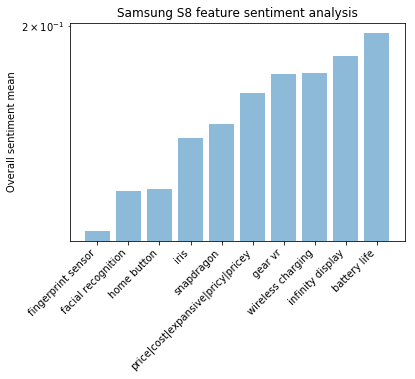

In [120]:
s8_mean = s8_alltime_sentiment.sort_values('overall_mean')

x = s8_mean['feature']
y = s8_mean['overall_mean']
plt.bar(x, y, align='center', alpha=0.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Overall sentiment mean')
plt.title('Samsung S8 feature sentiment analysis')
plt.yscale('log')
 
plt.show()

Using the bar chart to show the overall ranking of most like/dislike features.

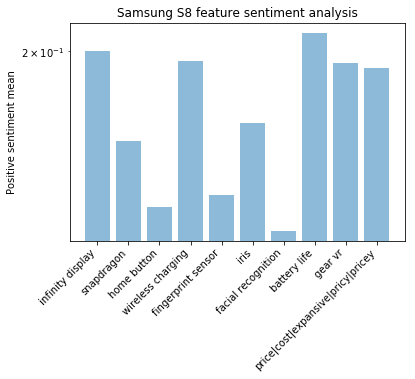

In [122]:
# s8_positive = s8_alltime_sentiment.sort_values('positive_mean')
s8_positive = s8_alltime_sentiment
x = s8_positive['feature']
y = s8_positive['positive_mean']
plt.bar(x, y, align='center', alpha=0.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Positive sentiment mean')
plt.title('Samsung S8 feature sentiment analysis')
plt.yscale('log')
 
plt.show()

Using the bar chart to show the positive ranking of most like features. <br>
Top 3 Positive features are : Battery life, infinity display, wireless charging.

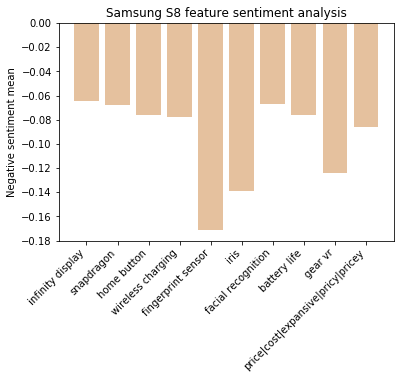

In [123]:
# s8_neg = s8_alltime_sentiment.sort_values('negative_mean', ascending=False)
s8_neg = s8_alltime_sentiment
x = s8_neg['feature']
y = s8_neg['negative_mean']
plt.bar(x, y, align='center', alpha=0.5, color='#CD853F')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Negative sentiment mean')
plt.title('Samsung S8 feature sentiment analysis')
# plt.yscale('log')
 
plt.show()

Using the bar chart to show the negative ranking of most dislike features. <br>
Top 3 Negaive features are : fingerprint sensor, iris and gear vr.

# IPhone 8 Feature

In [101]:
i8_df = iPDF[iPDF['i8'] == 1]

In [102]:
i8_oled_sentiment = get_feature_sentiment(i8_df, 'oled display')

Mean: 0.1082654205750223
Positive: 0.13221141805151895
Negative: -0.06125203989907394


In [103]:
i8_alltime_sentiment = i8_oled_sentiment.copy()

In [104]:
i8_wire_charging_sentiment = get_feature_sentiment(i8_df, 'wireless charging')

Mean: 0.13806058466427104
Positive: 0.16474331753996477
Negative: -0.09326075264380813


In [105]:
i8_ar_sentiment = get_feature_sentiment(i8_df, 'augmented reality')

Mean: 0.12991031803183814
Positive: 0.15764962475697167
Negative: -0.08621283766154153


In [106]:
i8_a11_sentiment = get_feature_sentiment(i8_df, 'bionic')

Mean: 0.15066217553143665
Positive: 0.16798291553680034
Negative: -0.06880254727273755


In [107]:
i8_dual_camera_sentiment = get_feature_sentiment(i8_df, 'dual camera')

Mean: 0.11786515323533256
Positive: 0.14350638940018887
Negative: -0.07920691614389677


In [108]:
i8_battery_sentiment = get_feature_sentiment(i8_df, 'battery life')

Mean: 0.14397066921786011
Positive: 0.1766822903776001
Negative: -0.10926066794242693


In [109]:
i8_facial_sentiment = get_feature_sentiment(i8_df, 'facial recognition')

Mean: 0.10167958350146171
Positive: 0.12593000482131672
Negative: -0.08353775212146322


In [110]:
i8_fingerprint_sentiment = get_feature_sentiment(i8_df, 'fingerprint sensor')

Mean: 0.08872997221217224
Positive: 0.11883329412483515
Negative: -0.07848130086541102


In [111]:
i8_portrait_mode_sentiment = get_feature_sentiment(i8_df, 'portrait mode')

Mean: 0.17698338470681638
Positive: 0.22286711588616767
Negative: -0.18253569533044722


In [112]:
i8_price_sentiment = get_feature_sentiment(i8_df, 'price|cost|expansive|pricy|pricey')

Mean: 0.13096050507146403
Positive: 0.17862584064393663
Negative: -0.10564428001151045


In [113]:
i8_alltime_sentiment = i8_alltime_sentiment.append(i8_wire_charging_sentiment)
i8_alltime_sentiment = i8_alltime_sentiment.append(i8_ar_sentiment)
i8_alltime_sentiment = i8_alltime_sentiment.append(i8_a11_sentiment)
i8_alltime_sentiment = i8_alltime_sentiment.append(i8_dual_camera_sentiment)
i8_alltime_sentiment = i8_alltime_sentiment.append(i8_battery_sentiment)
i8_alltime_sentiment = i8_alltime_sentiment.append(i8_facial_sentiment)
i8_alltime_sentiment = i8_alltime_sentiment.append(i8_fingerprint_sentiment)
i8_alltime_sentiment = i8_alltime_sentiment.append(i8_portrait_mode_sentiment)
i8_alltime_sentiment = i8_alltime_sentiment.append(i8_price_sentiment)

In [114]:
i8_alltime_sentiment

feature  \
oled display                       oled display                        
wireless charging                  wireless charging                   
augmented reality                  augmented reality                   
bionic                             bionic                              
dual camera                        dual camera                         
battery life                       battery life                        
facial recognition                 facial recognition                  
fingerprint sensor                 fingerprint sensor                  
portrait mode                      portrait mode                       
price|cost|expansive|pricy|pricey  price|cost|expansive|pricy|pricey   

                                   overall_mean  positive_mean  negative_mean  
oled display                       0.108265      0.132211      -0.061252       
wireless charging                  0.138061      0.164743      -0.093261       
augmented reality                  0.129910      0.157650      -0.086213       
bionic                             0.150662      0.167983      -0.068803       
dual camera                        0.117865      0.143506      -0.079207       
battery life                       0.143971      0.176682      -0.109261       
facial recognition                 0.101680      0.125930      -0.083538       
fingerprint sensor                 0.088730      0.118833      -0.078481       
portrait mode                      0.176983      0.222867      -0.182536       
price|cost|expansive|pricy|pricey  0.130961      0.178626      -0.105644

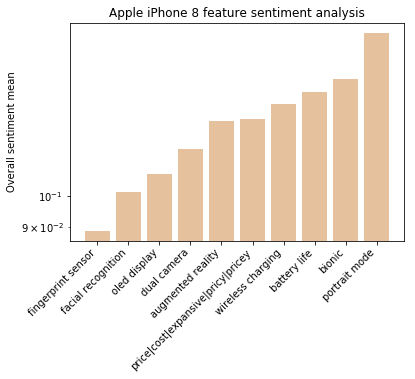

In [115]:
i8_mean = i8_alltime_sentiment.sort_values('overall_mean')

x = i8_mean['feature']
y = i8_mean['overall_mean']
plt.bar(x, y, align='center', alpha=0.5, color='#CD853F')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Overall sentiment mean')
plt.title('Apple iPhone 8 feature sentiment analysis')
plt.yscale('log')
 
plt.show()

Using the bar chart to present the overall ranking of features sentiment.
Top 3 features are portrait mode, bionic and battery life.

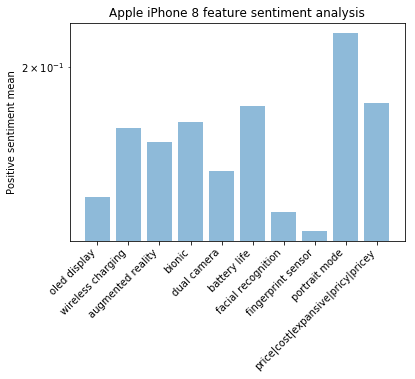

In [124]:
#i8_pos = i8_alltime_sentiment.sort_values('positive_mean')
i8_pos = i8_alltime_sentiment
x = i8_pos['feature']
y = i8_pos['positive_mean']
plt.bar(x, y, align='center', alpha=0.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Positive sentiment mean')
plt.title('Apple iPhone 8 feature sentiment analysis')
plt.yscale('log')
 
plt.show()

Using the bar chart to show the positive ranking of most like features. <br>
Top 3 Positive features are : portrait mode, price, battery life.

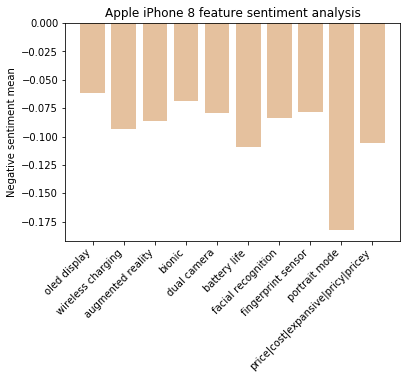

In [125]:
#i8_neg = i8_alltime_sentiment.sort_values('negative_mean', ascending=False)
i8_neg = i8_alltime_sentiment
x = i8_neg['feature']
y = i8_neg['negative_mean']
plt.bar(x, y, align='center', alpha=0.5, color='#CD853F')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Negative sentiment mean')
plt.title('Apple iPhone 8 feature sentiment analysis')
# plt.yscale('log')
 
plt.show()

Using the bar chart to show the negative ranking of most dislike features. <br>
Top 3 Negative features are : portrait mode, battery life and price.

# IPhone X Feature

In [118]:
iX_df = iPDF[iPDF['iX'] == 1]

In [126]:
iX_wire_charging_sentiment = get_feature_sentiment(iX_df, 'wireless charging')

Mean: 0.14477236777957866
Positive: 0.161766040043546
Negative: -0.08429221461202031


In [127]:
iX_alltime_sentiment = iX_wire_charging_sentiment.copy()

In [128]:
iX_face_id_sentiment = get_feature_sentiment(iX_df, 'face id')

Mean: 0.1339620287578133
Positive: 0.1597665064068964
Negative: -0.07047495191526844


In [129]:
iX_a11_sentiment = get_feature_sentiment(iX_df, 'bionic')

Mean: 0.14853052871802339
Positive: 0.16386056038316296
Negative: -0.06319034275552766


In [130]:
iX_home_button_sentiment = get_feature_sentiment(iX_df, 'home button')

Mean: 0.13411057297359605
Positive: 0.149368712793722
Negative: -0.0736910646140634


In [131]:
iX_ar_sentiment = get_feature_sentiment(iX_df, 'augmented reality')

Mean: 0.12061276688982592
Positive: 0.15185316813453859
Negative: -0.10995302956144522


In [132]:
iX_battery_sentiment = get_feature_sentiment(iX_df, 'battery life')

Mean: 0.13353555293827873
Positive: 0.15326618388392607
Negative: -0.07810203481076172


In [133]:
iX_dual_camera_sentiment = get_feature_sentiment(iX_df, 'dual camera')

Mean: 0.15197968686550142
Positive: 0.1629229873447684
Negative: -0.046451225315268636


In [134]:
iX_facial_sentiment = get_feature_sentiment(iX_df, 'facial recognition')

Mean: 0.11845193415747
Positive: 0.13483114357589585
Negative: -0.056155925295299246


In [135]:
iX_glassback_sentiment = get_feature_sentiment(iX_df, 'glass back')

Mean: 0.12836591792342314
Positive: 0.13944735480455883
Negative: -0.0533812889130544


In [136]:
iX_charging_pad_sentiment = get_feature_sentiment(iX_df, 'charging pad')

Mean: 0.14777771300463136
Positive: 0.16496970724289925
Negative: -0.09897469441668583


In [137]:
iX_price_sentiment = get_feature_sentiment(iX_df, 'price|cost|expansive|pricy|pricey')

Mean: 0.1251747669369225
Positive: 0.1540167305404533
Negative: -0.08435672315843248


In [138]:
iX_alltime_sentiment = iX_alltime_sentiment.append(iX_face_id_sentiment)
iX_alltime_sentiment = iX_alltime_sentiment.append(iX_a11_sentiment)
iX_alltime_sentiment = iX_alltime_sentiment.append(iX_home_button_sentiment)
iX_alltime_sentiment = iX_alltime_sentiment.append(iX_ar_sentiment)
iX_alltime_sentiment = iX_alltime_sentiment.append(iX_dual_camera_sentiment)
iX_alltime_sentiment = iX_alltime_sentiment.append(iX_glassback_sentiment)
iX_alltime_sentiment = iX_alltime_sentiment.append(iX_charging_pad_sentiment)
iX_alltime_sentiment = iX_alltime_sentiment.append(iX_price_sentiment)
iX_alltime_sentiment

feature  \
wireless charging                  wireless charging                   
face id                            face id                             
bionic                             bionic                              
home button                        home button                         
augmented reality                  augmented reality                   
dual camera                        dual camera                         
glass back                         glass back                          
charging pad                       charging pad                        
price|cost|expansive|pricy|pricey  price|cost|expansive|pricy|pricey   

                                   overall_mean  positive_mean  negative_mean  
wireless charging                  0.144772      0.161766      -0.084292       
face id                            0.133962      0.159767      -0.070475       
bionic                             0.148531      0.163861      -0.063190       
home button                        0.134111      0.149369      -0.073691       
augmented reality                  0.120613      0.151853      -0.109953       
dual camera                        0.151980      0.162923      -0.046451       
glass back                         0.128366      0.139447      -0.053381       
charging pad                       0.147778      0.164970      -0.098975       
price|cost|expansive|pricy|pricey  0.125175      0.154017      -0.084357

In [ ]:
#ix_mean = iX_alltime_sentiment.sort_values('overall_mean')
ix_mean = iX_alltime_sentiment

x = ix_mean['feature']
y = ix_mean['overall_mean']
plt.bar(x, y, align='center', alpha=0.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Overall sentiment mean')
plt.title('Apple iPhone X feature sentiment analysis')
plt.yscale('log')
 
plt.show()

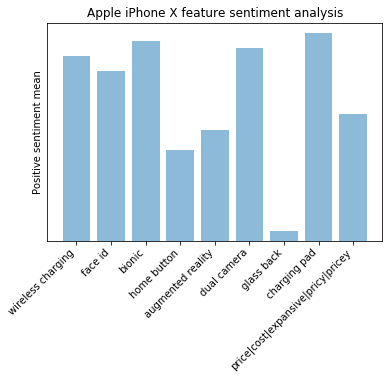

In [141]:
#ix_pro = iX_alltime_sentiment.sort_values('positive_mean')
ix_pro = iX_alltime_sentiment
x = ix_pro['feature']
y = ix_pro['positive_mean']
plt.bar(x, y, align='center', alpha=0.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Positive sentiment mean')
plt.title('Apple iPhone X feature sentiment analysis')
plt.yscale('log')
 
plt.show()

Using the bar chart to show the positive ranking of most like features. <br>
Top 3 Positive features are : charging pad, bonic, dual camera.

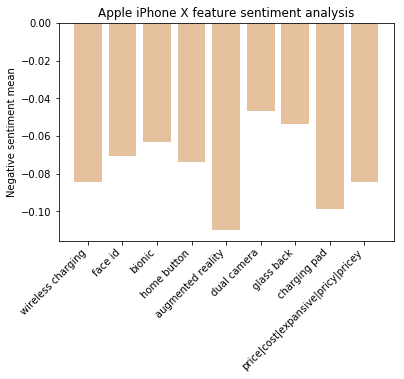

In [140]:
# ix_neg = iX_alltime_sentiment.sort_values('negative_mean', ascending=False)
ix_neg = iX_alltime_sentiment

x = ix_neg['feature']
y = ix_neg['negative_mean']
plt.bar(x, y, align='center', alpha=0.5, color='#CD853F')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Negative sentiment mean')
plt.title('Apple iPhone X feature sentiment analysis')
# plt.yscale('log')
 
plt.show()

Using the bar chart to show the negative ranking of most like features. <br>
Top 3 Negative features are : augmented reality, charging pad, price.

# Before and After launch comparison

In order to understand how people reacted before and after product launch, we use a month before and after 2017/3/29 as the time frame to do the analysis. 

In [143]:
s8DF['Published Date (GMT-04:00) New York'] = pd.to_datetime(s8DF['Published Date (GMT-04:00) New York'])

In [144]:
s8_b4_launch = get_feature_df(s8DF,
                              ['infinity display',
                               'snapdragon',
                               'home button',
                               'wireless charging',
                               'fingerprint sensor',
                               'iris','facial recognition',
                               'battery life',
                               'gear vr','price|cost|expansive|pricy|pricey'],
                              '20170301', '20170329')

Mean: 0.09971490420522704
Positive: 0.11479053220183448
Negative: -0.034642728303442595
Mean: 0.09971490420522704
Positive: 0.11479053220183448
Negative: -0.034642728303442595
Mean: 0.12392471662937345
Positive: 0.1460709795599144
Negative: -0.07728842456607797
Mean: 0.10406582645427948
Positive: 0.12058009483879051
Negative: -0.06724943067666346
Mean: 0.12363419024123688
Positive: 0.1324606447204327
Negative: -0.03167311207311206
Mean: -0.03573741581646951
Positive: 0.11124098250246722
Negative: -0.4289121360169605
Mean: 0.10952830467146735
Positive: 0.12242580767380609
Negative: -0.04073001793538817
Mean: 0.0920097359252679
Positive: 0.11840994926984345
Negative: -0.06184075926054535
Mean: 0.14477902078789787
Positive: 0.15624630664313094
Negative: -0.04323593073593074
Mean: 0.149299360443563
Positive: 0.1512023885796437
Negative: -0.008828671328671326
Mean: 0.13477972901611918
Positive: 0.1648303105448557
Negative: -0.0849823079141779


In [145]:
s8_b4_launch

feature  \
infinity display                   infinity display                    
snapdragon                         snapdragon                          
home button                        home button                         
wireless charging                  wireless charging                   
fingerprint sensor                 fingerprint sensor                  
iris                               iris                                
facial recognition                 facial recognition                  
battery life                       battery life                        
gear vr                            gear vr                             
price|cost|expansive|pricy|pricey  price|cost|expansive|pricy|pricey   

                                   overall_mean  positive_mean  negative_mean  
infinity display                   0.099715      0.114791      -0.034643       
snapdragon                         0.123925      0.146071      -0.077288       
home button                        0.104066      0.120580      -0.067249       
wireless charging                  0.123634      0.132461      -0.031673       
fingerprint sensor                -0.035737      0.111241      -0.428912       
iris                               0.109528      0.122426      -0.040730       
facial recognition                 0.092010      0.118410      -0.061841       
battery life                       0.144779      0.156246      -0.043236       
gear vr                            0.149299      0.151202      -0.008829       
price|cost|expansive|pricy|pricey  0.134780      0.164830      -0.084982

In [146]:
s8_after_launch = get_feature_df(s8DF,
                              ['infinity display',
                               'snapdragon',
                               'home button',
                               'wireless charging',
                               'fingerprint sensor',
                               'iris','facial recognition',
                               'battery life',
                               'gear vr','price|cost|expansive|pricy|pricey'],
                              '20170329', '20170430')

Mean: 0.17503445957327018
Positive: 0.1900332821366295
Negative: -0.06828266272936129
Mean: 0.17503445957327018
Positive: 0.1900332821366295
Negative: -0.06828266272936129
Mean: 0.15532136734417334
Positive: 0.17089133274144344
Negative: -0.07148032576102512
Mean: 0.1260937336756988
Positive: 0.1497528969321909
Negative: -0.08410719757080101
Mean: 0.16931351457301128
Positive: 0.18822537654269145
Negative: -0.0820809389829195
Mean: 0.11730721545396026
Positive: 0.15244847081479762
Negative: -0.1035690309130627
Mean: 0.1580931744161106
Positive: 0.17081616282467843
Negative: -0.07389666756656811
Mean: 0.1256028965094414
Positive: 0.1425520731409098
Negative: -0.0739435759001095
Mean: 0.1899774023795329
Positive: 0.1976166639318021
Negative: -0.08495972518192486
Mean: 0.1731913754433883
Positive: 0.19358446476225716
Negative: -0.11386698170788839
Mean: 0.15960255469342788
Positive: 0.18432009185293027
Negative: -0.08352740768670544


In [147]:
s8_after_launch

feature  \
infinity display                   infinity display                    
snapdragon                         snapdragon                          
home button                        home button                         
wireless charging                  wireless charging                   
fingerprint sensor                 fingerprint sensor                  
iris                               iris                                
facial recognition                 facial recognition                  
battery life                       battery life                        
gear vr                            gear vr                             
price|cost|expansive|pricy|pricey  price|cost|expansive|pricy|pricey   

                                   overall_mean  positive_mean  negative_mean  
infinity display                   0.175034      0.190033      -0.068283       
snapdragon                         0.155321      0.170891      -0.071480       
home button                        0.126094      0.149753      -0.084107       
wireless charging                  0.169314      0.188225      -0.082081       
fingerprint sensor                 0.117307      0.152448      -0.103569       
iris                               0.158093      0.170816      -0.073897       
facial recognition                 0.125603      0.142552      -0.073944       
battery life                       0.189977      0.197617      -0.084960       
gear vr                            0.173191      0.193584      -0.113867       
price|cost|expansive|pricy|pricey  0.159603      0.184320      -0.083527

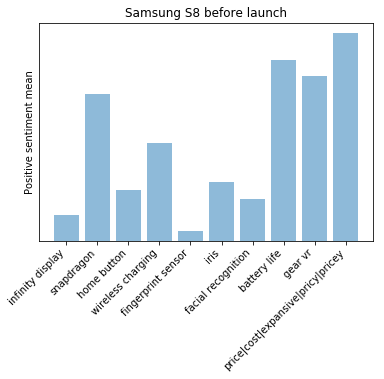

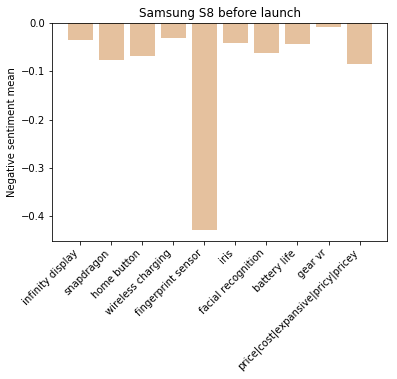

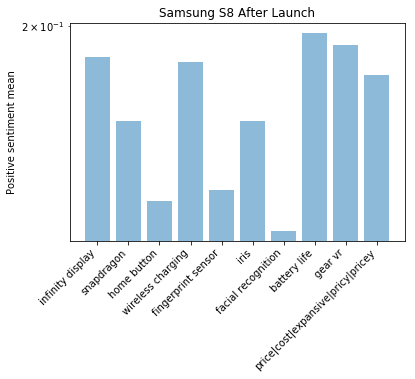

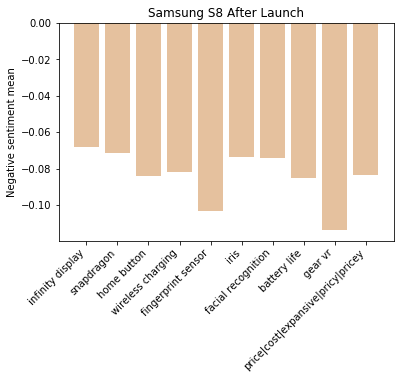

In [164]:
x = s8_b4_launch['feature']
y = s8_b4_launch['positive_mean']
plt.bar(x, y, align='center', alpha=0.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Positive sentiment mean')
plt.title('Samsung S8 before launch')
plt.yscale('log')
 
plt.show()

x = s8_b4_launch['feature']
y = s8_b4_launch['negative_mean']
plt.bar(x, y, align='center', alpha=0.5, color='#CD853F')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Negative sentiment mean')
plt.title('Samsung S8 before launch')
# plt.yscale('log')
 
plt.show()


x = s8_after_launch['feature']
y = s8_after_launch['positive_mean']
plt.bar(x, y, align='center', alpha=0.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Positive sentiment mean')
plt.title('Samsung S8 After Launch')
plt.yscale('log')
 
plt.show()

x = s8_after_launch['feature']
y = s8_after_launch['negative_mean']
plt.bar(x, y, align='center', alpha=0.5, color='#CD853F')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Negative sentiment mean')
plt.title('Samsung S8 After Launch')
# plt.yscale('log')
 
plt.show()

From the graph above, we can see that before s8 launched, people didn't show much negative reaction to the features, but after the product launched, the data shows that people disliked the fingerprint sensor and the gear vr features most.The battery life remains the most like feature before and after launched.

# iPhone 8 before and after launch comparison

In [149]:
iPDF['Published Date (GMT-04:00) New York'] = pd.to_datetime(iPDF['Published Date (GMT-04:00) New York'])

In [150]:
i8_b4_launch = get_feature_df(iPDF,
                              ['oled display',
                               'snapdragon',
                               'augmented reality',
                               'wireless charging',
                               'dual camera',
                               'battery life','facial recognition',
                               'fingerprint sensor',
                               'portrait mode','price|cost|expansive|pricy|pricey'],
                              '20170822', '20170922')

Mean: 0.15772698751905787
Positive: 0.16860771899687346
Negative: -0.025964662064299652
Mean: 0.15772698751905787
Positive: 0.16860771899687346
Negative: -0.025964662064299652
Mean: 0.16576830375643714
Positive: 0.18469506807982305
Negative: -0.056598446196660476
Mean: 0.15782911277588563
Positive: 0.17360959520680636
Negative: -0.07997061712525638
Mean: 0.15389113113663108
Positive: 0.1720587163600983
Negative: -0.1129074035065692
Mean: 0.14516184942267163
Positive: 0.1616318930558479
Negative: -0.14973672321886614
Mean: 0.13506310051601922
Positive: 0.15547890208638238
Negative: -0.11192597182618191
Mean: 0.13058103189053263
Positive: 0.14643933783665553
Negative: -0.06663510927265397
Mean: 0.14847419185832164
Positive: 0.15022553994553137
Negative: -0.017903876426603706
Mean: 0.1708290118985748
Positive: 0.17930963141864625
Negative: -0.10819900702889422
Mean: 0.1454059406161002
Positive: 0.1844705294218998
Negative: -0.11503661689018117


In [153]:
i8_after_launch = get_feature_df(iPDF,
                              ['oled display',
                               'snapdragon',
                               'augmented reality',
                               'wireless charging',
                               'dual camera',
                               'battery life','facial recognition',
                               'fingerprint sensor',
                               'portrait mode','price|cost|expansive|pricy|pricey'],
                              '20170922', '20171022')

Mean: 0.1447791122589309
Positive: 0.15740547418076065
Negative: -0.057396878432931286
Mean: 0.1447791122589309
Positive: 0.15740547418076065
Negative: -0.057396878432931286
Mean: 0.13807057482784396
Positive: 0.16260207872002921
Negative: -0.1193584469642911
Mean: 0.12764394167756052
Positive: 0.17742562313069937
Negative: -0.1230666542075724
Mean: 0.15127964102112085
Positive: 0.1839641634892269
Negative: -0.10558932059068589
Mean: 0.1630593471424673
Positive: 0.1908280100626893
Negative: -0.07766080108958913
Mean: 0.15262764135048584
Positive: 0.1951526302357462
Negative: -0.12792776032409847
Mean: 0.10411320442197564
Positive: 0.12414770531137827
Negative: -0.0545206579882011
Mean: 0.12832596825491355
Positive: 0.15449501019462708
Negative: -0.09436281237701694
Mean: 0.1777010726864974
Positive: 0.24402285623242473
Negative: -0.19134748729095868
Mean: 0.13865093357596367
Positive: 0.18748424629336952
Negative: -0.09746936467457902


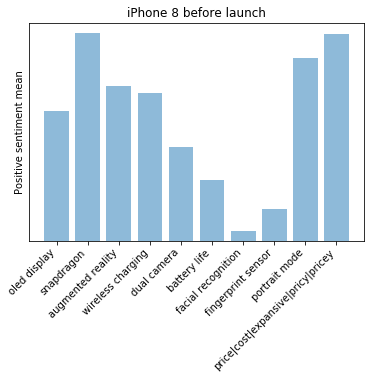

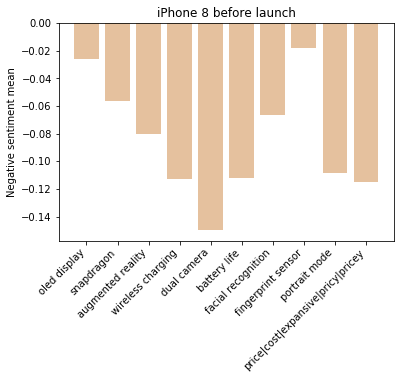

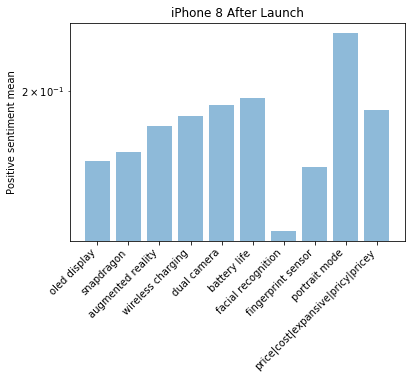

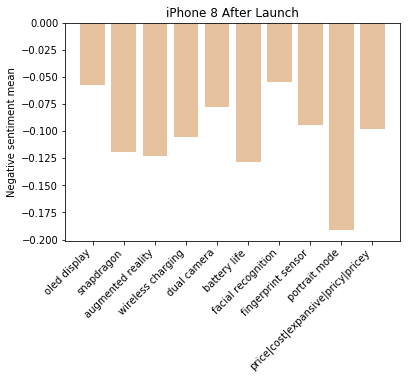

In [165]:
x = i8_b4_launch['feature']
y = i8_b4_launch['positive_mean']
plt.bar(x, y, align='center', alpha=0.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Positive sentiment mean')
plt.title('iPhone 8 before launch')
plt.yscale('log')
 
plt.show()

x = i8_b4_launch['feature']
y = i8_b4_launch['negative_mean']
plt.bar(x, y, align='center', alpha=0.5, color='#CD853F')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Negative sentiment mean')
plt.title('iPhone 8 before launch')
# plt.yscale('log')
 
plt.show()


x = i8_after_launch['feature']
y = i8_after_launch['positive_mean']
plt.bar(x, y, align='center', alpha=0.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Positive sentiment mean')
plt.title('iPhone 8 After Launch')
plt.yscale('log')
 
plt.show()

x = i8_after_launch['feature']
y = i8_after_launch['negative_mean']
plt.bar(x, y, align='center', alpha=0.5, color='#CD853F')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Negative sentiment mean')
plt.title('iPhone 8 After Launch')
# plt.yscale('log')
 
plt.show()

From the graph above, we can see that before iphon8 launched, people didn't expect much on the battery life, but after launched, the response to battery life feature were positive. However, for the dual camera, people tended to have lower expectation on this feature, but after iphone 8 launched, negative response to dual camera decrease. Out of expectation, the negative reaction about portrait mode features increased.

# iPhone X before and after launch comparison

In [148]:
iXDF = iPDF[iPDF['iX'] == 1]

In [155]:
iXDF['Published Date (GMT-04:00) New York'] = pd.to_datetime(iXDF['Published Date (GMT-04:00) New York'])

/Users/Kiyashy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [156]:
iXDF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40118 entries, 103 to 380285
Data columns (total 21 columns):
index                                     40118 non-null int64
Sound Bite Text                           40118 non-null object
Title                                     40118 non-null object
Post Type                                 40118 non-null object
Published Date (GMT-04:00) New York       40118 non-null datetime64[ns]
Source Type                               40118 non-null object
No. of Followers/Daily Unique Visitors    40118 non-null float64
Author Gender                             40118 non-null object
Positive Objects                          8198 non-null object
Negative Objects                          3982 non-null object
Author Location - Country 1               40118 non-null object
lower_text                                40118 non-null object
clear_text                                40118 non-null object
clear_text_str                            40118 no

In [157]:
iX_b4_launch = get_feature_df(iXDF,
                              ['wireless charging',
                               'face id',
                               'bionic',
                               'home button',
                               'augmented reality',
                               'dual camera','glass back',
                               'charging pad','price|cost|expansive|pricy|pricey'],
                              '20170822', '20170922')

Mean: 0.14954413586423043
Positive: 0.16433087160585552
Negative: -0.10236445950168817
Mean: 0.14954413586423043
Positive: 0.16433087160585552
Negative: -0.10236445950168817
Mean: 0.13823699687099764
Positive: 0.16124310535401123
Negative: -0.06961663197530969
Mean: 0.16032538728889567
Positive: 0.1676541980270981
Negative: -0.08897209953714519
Mean: 0.1414423289191486
Positive: 0.15149234271453316
Negative: -0.09519648559801962
Mean: 0.14353664304401448
Positive: 0.1552421773353307
Negative: -0.0725360080200974
Mean: 0.15678814937429286
Positive: 0.1625727736319085
Negative: -0.05581522034131924
Mean: 0.14444043742854232
Positive: 0.15051815713920824
Negative: -0.056819149752267546
Mean: 0.13832708506911273
Positive: 0.15492860570202593
Negative: -0.11787833072277519
Mean: 0.12976621036559663
Positive: 0.15439202048125614
Negative: -0.10368336904009864


In [158]:
iX_after_launch = get_feature_df(iXDF,
                              ['wireless charging',
                               'face id',
                               'bionic',
                               'home button',
                               'augmented reality',
                               'dual camera','glass back',
                               'charging pad','price|cost|expansive|pricy|pricey'],
                               '20170922', '20171022')

Mean: 0.14002487131265864
Positive: 0.1583025782453074
Negative: -0.07125609900333636
Mean: 0.14002487131265864
Positive: 0.1583025782453074
Negative: -0.07125609900333636
Mean: 0.12175599923058175
Positive: 0.15219500400936128
Negative: -0.06419316975767732
Mean: 0.13047838187717262
Positive: 0.15783637507016507
Negative: -0.0519765309093771
Mean: 0.13573724957505406
Positive: 0.15100148244827075
Negative: -0.05792460455127567
Mean: 0.09748499783711631
Positive: 0.15645200378483407
Negative: -0.14250440176931642
Mean: 0.16152846932066625
Positive: 0.17510414876297936
Negative: -0.048894562035187036
Mean: 0.12274623767391349
Positive: 0.1364795488642416
Negative: -0.04975847702884489
Mean: 0.15640399971865943
Positive: 0.1765382610754527
Negative: -0.07620139023348169
Mean: 0.12076830238518074
Positive: 0.15009840150209344
Negative: -0.06747541803375659


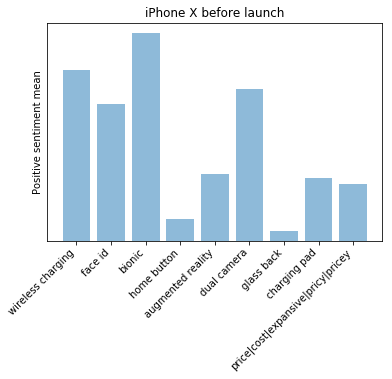

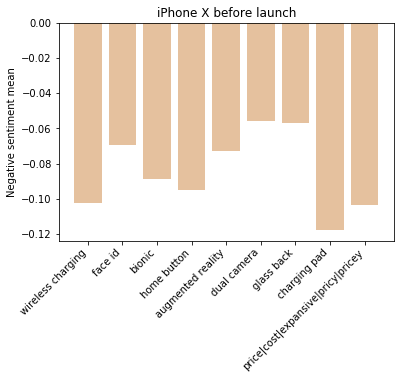

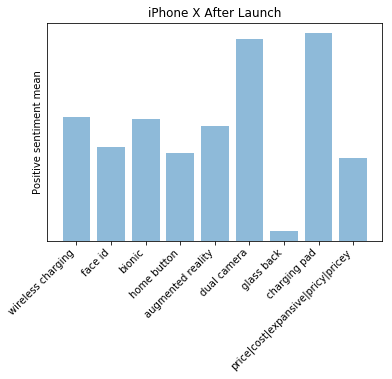

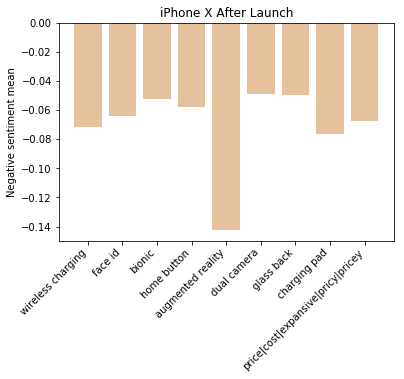

In [166]:
x = iX_b4_launch['feature']
y = iX_b4_launch['positive_mean']
plt.bar(x, y, align='center', alpha=0.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Positive sentiment mean')
plt.title('iPhone X before launch')
plt.yscale('log')
 
plt.show()

x = iX_b4_launch['feature']
y = iX_b4_launch['negative_mean']
plt.bar(x, y, align='center', alpha=0.5, color='#CD853F')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Negative sentiment mean')
plt.title('iPhone X before launch')
# plt.yscale('log')
 
plt.show()


x = iX_after_launch['feature']
y = iX_after_launch['positive_mean']
plt.bar(x, y, align='center', alpha=0.5)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Positive sentiment mean')
plt.title('iPhone X After Launch')
plt.yscale('log')
 
plt.show()

x = iX_after_launch['feature']
y = iX_after_launch['negative_mean']
plt.bar(x, y, align='center', alpha=0.5, color='#CD853F')
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.ylabel('Negative sentiment mean')
plt.title('iPhone X After Launch')
# plt.yscale('log')
 
plt.show()

In [175]:
iX_b4_launch

feature  \
wireless charging                  wireless charging                   
face id                            face id                             
bionic                             bionic                              
home button                        home button                         
augmented reality                  augmented reality                   
dual camera                        dual camera                         
glass back                         glass back                          
charging pad                       charging pad                        
price|cost|expansive|pricy|pricey  price|cost|expansive|pricy|pricey   

                                   overall_mean  positive_mean  negative_mean  
wireless charging                  0.149544      0.164331      -0.102364       
face id                            0.138237      0.161243      -0.069617       
bionic                             0.160325      0.167654      -0.088972       
home button                        0.141442      0.151492      -0.095196       
augmented reality                  0.143537      0.155242      -0.072536       
dual camera                        0.156788      0.162573      -0.055815       
glass back                         0.144440      0.150518      -0.056819       
charging pad                       0.138327      0.154929      -0.117878       
price|cost|expansive|pricy|pricey  0.129766      0.154392      -0.103683

In [183]:
result_iX = pd.merge(iX_b4_launch,iX_after_launch, how ="inner", on="feature")
result_iX

feature  overall_mean_x  positive_mean_x  \
0  wireless charging                  0.149544        0.164331          
1  face id                            0.138237        0.161243          
2  bionic                             0.160325        0.167654          
3  home button                        0.141442        0.151492          
4  augmented reality                  0.143537        0.155242          
5  dual camera                        0.156788        0.162573          
6  glass back                         0.144440        0.150518          
7  charging pad                       0.138327        0.154929          
8  price|cost|expansive|pricy|pricey  0.129766        0.154392          

   negative_mean_x  overall_mean_y  positive_mean_y  negative_mean_y  
0 -0.102364         0.140025        0.158303        -0.071256         
1 -0.069617         0.121756        0.152195        -0.064193         
2 -0.088972         0.130478        0.157836        -0.051977         
3 -0.095196         0.135737        0.151001        -0.057925         
4 -0.072536         0.097485        0.156452        -0.142504         
5 -0.055815         0.161528        0.175104        -0.048895         
6 -0.056819         0.122746        0.136480        -0.049758         
7 -0.117878         0.156404        0.176538        -0.076201         
8 -0.103683         0.120768        0.150098        -0.067475

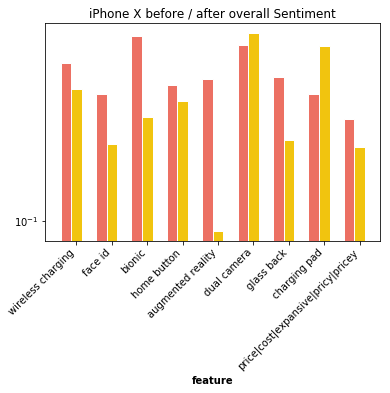

In [197]:
iX_f = result_iX['feature']
iX_b4o = result_iX['overall_mean_x']
iX_afo = result_iX['overall_mean_y']

barWidth = 0.3

r1 = np.arange(len(iX_f))
r2 = [x + barWidth for x in r1]
plt.bar(r1,iX_b4o, color='#EC7063', width=barWidth, edgecolor='white', label='b4')
plt.bar(r2,iX_afo, color='#F1C40F', width=barWidth, edgecolor='white', label='af')
plt.xlabel('feature', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(iX_f))], result_iX['feature'].values)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.yscale('log')
plt.title('iPhone X before / after overall Sentiment')
plt.show()

From the comparison graph about iphone X before and after launched, we can clearly see that people had really high expectiation to augmented reality, but the expectation became dissapointed after product launched. About charging pad, it turned out to be the features that brought more positive surprise for customers.

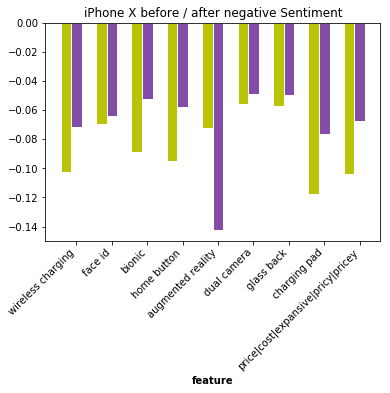

In [199]:
iX_f = result_iX['feature']
iX_b4o = result_iX['negative_mean_x']
iX_afo = result_iX['negative_mean_y']

barWidth = 0.3

r1 = np.arange(len(iX_f))
r2 = [x + barWidth for x in r1]
plt.bar(r1,iX_b4o, color='#b9c406', width=barWidth, edgecolor='white', label='b4')
plt.bar(r2,iX_afo, color='#824ca7', width=barWidth, edgecolor='white', label='af')
plt.xlabel('feature', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(iX_f))], result_iX['feature'].values)
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title('iPhone X before / after negative Sentiment')
# plt.yscale('log')
plt.show()

Before iphone X launched, people had some concerns about augmented reality, so it showed some negative reaction on this feature. After launched, we can see from the data that people truly didn't buy-in the augmented reality feature which become the most dislike feature for iphone X.